 Mateusz Hawrot | 



### The assumptions based on the task description:
- Problem based on the multi-label classification where we need to distinguish whether a certain sentence is neutral, cyberbullying or hate speech
- Dataset is given with training and testing examples - initially, I split data in 80/20 proportion for testing in training. In later development, I used the given training set (approx. 10k) for the training and testing test (approx. 1k) for validation 
- I performed data-cleaning for the given dataset. However, finally, I am not certainly happy with the results. I think too much data were extracted in the preprocessing stage. I could not explore more due to the deadline for submission. Polish stopwords extracted using data from [bieli/stopwords git repo](https://github.com/bieli/stopwords)
- I have experimented with the architecture of the NN. Changed some activation functions, added dropout to deal with the overfitting. 
- For the Embedding, I have used Glove for polish sentences. The model was taken from this repo: [polish-nlp-resources](https://github.com/sdadas/polish-nlp-resources)
- In the further step I could implement a Transformer for the network such as BERT and try to increase the accuracy of the model. 


---



I think it is worth mentioning that during the preprocessing I have noticed that the distribution of the data between the labels overweights towards neutral sentences (around 82%). I think, for the further preprocessing steps it would be rational to balance the data. I did not do it for the notebook, however, I think it is a good idea for the further data argumentation process. 


---



The final distribution for the loss and accuracy of the model looks like this:


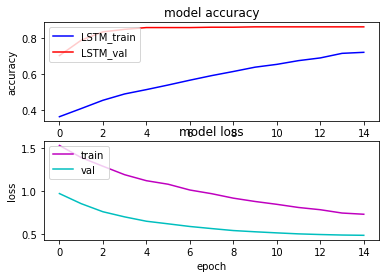

### Possible solution for model deployment:

For the model demployment I could use a service called SageMaker provided by AWS. The following steps would be required:
- Create a Notebook in SageMaker with a new instance of S3 bucket (which will serve all the files required for the model)
- Upload a jupyter notebook to the instance created in SageMaker - we need to add additional imports to the notebook:
  - import sagemaker, boto3
  - assign the prefix and initialise the session using boto3
  - assign the region and role with sagemaker
  - upload files into S3 instance using configured before boto3
  - train the model and validate the input with sagemaker
  - deploy the model with sagemaker






Start of the notebook

In [ ]:
import pandas as pd
import re
import nltk
import os
from sklearn.model_selection import train_test_split
import numpy as np

from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.preprocessing.text import text_to_word_sequence
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip task_6-2.zip

Archive:  task_6-2.zip
  inflating: training_set_clean_only_text.txt  
  inflating: training_set_clean_only_tags.txt  


In [ ]:
!unzip task6_test.zip

Archive:  task6_test.zip
   creating: Task6/
   creating: Task6/task 01/
  inflating: Task6/task 01/evaulate1.pl  
  inflating: Task6/task 01/test_set_clean_only_tags.txt  
  inflating: Task6/task 01/test_set_clean_only_text.txt  
   creating: Task6/task 02/
  inflating: Task6/task 02/evaulate2.pl  
  inflating: Task6/task 02/test_set_only_tags.txt  
  inflating: Task6/task 02/test_set_only_text.txt  


In [ ]:
!unzip /content/gdrive/MyDrive/Engineering/nlp-assignment/glove.zip


Archive:  /content/gdrive/MyDrive/Engineering/nlp-assignment/glove.zip
  inflating: glove_100_3_polish.txt  


In [ ]:
def load_training():
  # Load training data (sentences)
  train_data = df = pd.read_csv('training_set_clean_only_text.txt', delimiter = "\t", header=None)
  train_data.columns = ["text"]

  # Load lables
  train_labels = df = pd.read_csv('training_set_clean_only_tags.txt', delimiter = "\t", header=None)

  # Add labels into training dataframe
  train_data['label'] = train_labels

  return train_data

  

def load_test():
  # Load test data (sentences)
  test_data = df = pd.read_csv('test_set_only_text.txt', delimiter = "\t", header=None)
  test_data.columns = ["text"]

  # Load test lables
  test_label = df = pd.read_csv('test_set_only_tags.txt', delimiter = "\t", header=None)

  # Add labels into test dataframe
  test_data['label'] = test_label

  return test_data

In [ ]:
# Load the train and test data
train_data = load_training()
test_data = load_test()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


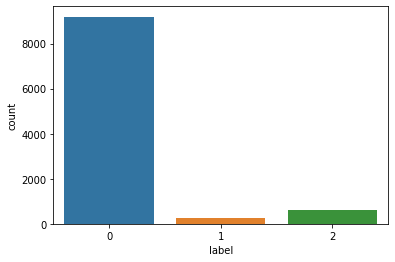

In [ ]:
# Visualise the distribution between the classes
import seaborn as sns
sns.countplot('label',data=train_data)

In [ ]:
# Check for missing values
train_data.isnull().sum()

# Drop the duplicates
train_data.drop_duplicates(subset=['text'])

,text,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0
...,...,...
10036,@anonymized_account Ty zagrasz? Nie wiedziałem 😉,0
10037,@anonymized_account @anonymized_account A VAR ...,0
10038,@anonymized_account @anonymized_account Szanow...,0
10039,@anonymized_account @anonymized_account @anony...,0


Data Cleaning
- stopwords
- polish letter replacement
- remote 'http'
- remove signs
- remove empty spaces
- remove numbers
- remove 'anonymizedaccount' word in each sentence

In [ ]:
def load_stop_words():
  with open('polish.stopwords.txt', encoding="utf-8", newline='\n') as f:
    stopwords = f.readlines()
  stopwords = [x[:-1] for x in stopwords]
  return stopwords

def replacePolishLetters(text):
    patterns = [ (r'ł', 'l'), 
                 (r'ó', 'o'),
                 (r'ą', 'a'),
                 (r'ć', 'c'),
                 (r'ę', 'e'),
                 (r'ń', 'n'),
                 (r'ś', 's'),
                 (r'ź', 'z'),
                 (r'ż', 'z')]
  
    for (pattern, repl) in patterns:
        text = re.sub(pattern, repl, text)
    return text

def removeStopwords(text):
    final_tokens = []
    tokens = text.split()
    stopwords_list = polish_stopwords
    
    for word in tokens:
        if (word not in stopwords_list):
            final_tokens.append(word)
            
    text = " ".join(final_tokens)
  
    return text

def clean_data(text):
    text = re.sub('\[.*?\]', '', text) # remove sings
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove webiste addresses
    text = re.sub('<.*?>+', '', text) 
    text = re.sub('\n', '', text) # remove empyt spaces
    text = re.sub('\w*\d\w*', '', text) 
    text = re.sub('[^a-zA-Z ]', '', text)
    text = re.sub('[0-9]', '', text) # remove numbers
    text = re.sub('anonymizedaccount', '', text) # remove @anonymized_account tags
    text = str(text).lower()
    return text





In [ ]:
# Apply the cleaning function to the dataframe
polish_stopwords = load_stop_words()
train_data['text']=train_data['text'].apply(removeStopwords) # remove stopwords
train_data['text']=train_data['text'].apply(replacePolishLetters) #replace polish letters

train_data['text']=train_data['text'].apply(clean_data) # clean the data
train_data.reset_index(drop=True, inplace=True) # reset the indexing from 0
preprocessed_train = train_data
preprocessed_train

,text,label,non-harmful,cyberbullying,hate_speech
0,dla faworytem tytulu cracovia zobaczymy typ sp...,0,1,0,0
1,brawo daria kibic dobre zle,0,1,0,0
2,super polski premier sklada kwiaty grobach k...,0,1,0,0
3,musi innej drogi mamy,0,1,0,0
4,odrzut natychmiastowy kwasna mina problem,0,1,0,0
...,...,...,...,...,...
10036,ty zagrasz nie wiedzialem,0,1,0,0
10037,a var mial poprawic jakosci sedziowania efek...,0,1,0,0
10038,szanowany kolega ladnie pozegnal,0,1,0,0
10039,a bic kazdy zwyciezca ligi wojewodzkiej gra...,0,1,0,0


Handle the lables for the training dataset:
- As the architecture will be predicting for three classes i.e. *non-harmful, cyberbullying and hate-speech* we need to prepare the lables are three dimentional tensor. 

**For instance:**
- non-harmful **(label 0)** : [1, 0, 0]
- cyberbullying **(label 1)** : [0, 1, 0]
- hate-speech **(label 2)** : [0, 0, 1]

In [ ]:
def non_harmful(label):
  if label == 0:
    return 1
  else:
    return 0

def cyberbullying(label):
  if label == 1:
    return 1
  
  else:
    return 0

def hate_speech(label):
  if label == 2:
    return 1
  else:
    return 0

preprocessed_train['non-harmful'] = preprocessed_train.apply(lambda x: non_harmful(x['label']),axis=1)
preprocessed_train['cyberbullying'] = preprocessed_train.apply(lambda x: cyberbullying(x['label']),axis=1)
preprocessed_train['hate_speech'] = preprocessed_train.apply(lambda x: hate_speech(x['label']),axis=1)
preprocessed_train


,text,label,non-harmful,cyberbullying,hate_speech
0,dla faworytem tytulu cracovia zobaczymy typ sp...,0,1,0,0
1,brawo daria kibic dobre zle,0,1,0,0
2,super polski premier sklada kwiaty grobach k...,0,1,0,0
3,musi innej drogi mamy,0,1,0,0
4,odrzut natychmiastowy kwasna mina problem,0,1,0,0
...,...,...,...,...,...
10036,ty zagrasz nie wiedzialem,0,1,0,0
10037,a var mial poprawic jakosci sedziowania efek...,0,1,0,0
10038,szanowany kolega ladnie pozegnal,0,1,0,0
10039,a bic kazdy zwyciezca ligi wojewodzkiej gra...,0,1,0,0


Train lables peraration

In [ ]:
labels_ext = preprocessed_train[['non-harmful', 'cyberbullying', 'hate_speech']] # take only the classes
y_train = labels_ext.values # assign class values for the label training set

y_train.shape # check the shape

(10041, 3)

*Test* Data and lables preparation

In [ ]:
test_data['text']=test_data['text'].apply(removeStopwords)
test_data['text']=test_data['text'].apply(replacePolishLetters)


test_data['text']=test_data['text'].apply(clean_data)
test_data.reset_index(drop=True, inplace=True)


test_data['non-harmful'] = test_data.apply(lambda x: non_harmful(x['label']),axis=1)
test_data['cyberbullying'] = test_data.apply(lambda x: cyberbullying(x['label']),axis=1)
test_data['hate_speech'] = test_data.apply(lambda x: hate_speech(x['label']),axis=1)


test_labels_ext = test_data[['non-harmful', 'cyberbullying', 'hate_speech']]

y_test = test_labels_ext.values

print(f'Test dataset has {len(test_data)} lenght and {test_data.shape} shape')
print(f'Test labels has {len(y_test)} lenght and {y_test.shape} shape')



Test dataset has 1000 lenght and (1000, 5) shape
Test labels has 1000 lenght and (1000, 3) shape


In [ ]:
X_train = preprocessed_train['text']
X_test = test_data['text']

In [ ]:
# Split the data into training and valid set
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 22543


In [ ]:
MAX_LENGTH = 30

from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (10041, 30)
Testing X Shape: (1000, 30)


In [ ]:
#GLOVE_EMB = 'glove.6B.300d.txt'
GLOVE_EMB = 'glove_100_3_polish.txt'
BATCH_SIZE = 256
EPOCHS = 15
MODEL_PATH = 'best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 1926321 word vectors.


In [ ]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = True)

In [ ]:
sequence_input = Input(shape = (MAX_LENGTH,), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.5)(embedding_sequences)

#x = Conv1D(64, 5, activation = 'relu')(x)  # initially activation was relu
x = Conv1D(64, 5)(x) 
x = LeakyReLU(0.2)(x) # add LeakyRelu
x = Bidirectional(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5))(x)
x = BatchNormalization(momentum=0.9)(x)
x = Dense(512, activation = 'tanh')(x) # initally activation was relu, changed to tanh just for explaration reason 
x = Dropout(0.5)(x)
x = Dense(512, activation = 'tanh')(x) # initally activation was relu, changed to tanh just for explaration reason 
x = Dropout(0.8)(x)
outputs = Dense(3, activation = 'softmax')(x) # softmax due to the multi-class use-case, 3 neuros on the output as we have 3 classes
model = tf.keras.Model(sequence_input, outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 30, 100)           2254300   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 30, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 26, 64)            32064     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 26, 64)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               66048     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512 

In [ ]:
learning_rate = 0.001

model.compile(optimizer = Adagrad(learning_rate = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
#ReduceLROnPlateau = ReduceLROnPlateau(factor = 0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on CPU...


In [ ]:
history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_test, y_test))


Epoch 1/15
40/40 [==============================] - 19s 314ms/step - loss: 1.5326 - accuracy: 0.3620 - val_loss: 0.9705 - val_accuracy: 0.7040
Epoch 2/15
40/40 [==============================] - 12s 297ms/step - loss: 1.3913 - accuracy: 0.4075 - val_loss: 0.8526 - val_accuracy: 0.7900
Epoch 3/15
40/40 [==============================] - 12s 302ms/step - loss: 1.2899 - accuracy: 0.4539 - val_loss: 0.7580 - val_accuracy: 0.8370
Epoch 4/15
40/40 [==============================] - 12s 297ms/step - loss: 1.1908 - accuracy: 0.4894 - val_loss: 0.6979 - val_accuracy: 0.8510
Epoch 5/15
40/40 [==============================] - 12s 297ms/step - loss: 1.1207 - accuracy: 0.5137 - val_loss: 0.6471 - val_accuracy: 0.8610
Epoch 6/15
40/40 [==============================] - 12s 304ms/step - loss: 1.0795 - accuracy: 0.5394 - val_loss: 0.6167 - val_accuracy: 0.8610
Epoch 7/15
40/40 [==============================] - 12s 297ms/step - loss: 1.0119 - accuracy: 0.5664 - val_loss: 0.5857 - val_accuracy: 0.8610

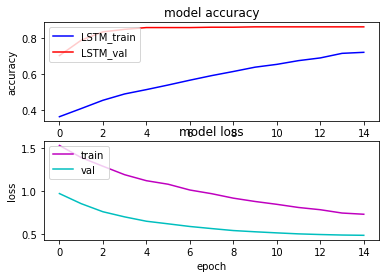

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c = 'b')
at.plot(history.history['val_accuracy'], c ='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc ='upper left')

al.plot(history.history['loss'], c ='m')
al.plot(history.history['val_loss'], c ='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

32/32 [==============================] - 0s 15ms/step - loss: 0.4826 - accuracy: 0.8650
Test Score:  0.48260533809661865
Test Accuracy:  0.8650000095367432


In [ ]:
# Save the model
model.save('/content/gdrive/MyDrive/Engineering/nlp-assignment/hawrot_model.h5') 